<a href="https://colab.research.google.com/github/SKumarAshutosh/machine_learning/blob/main/Outlier-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

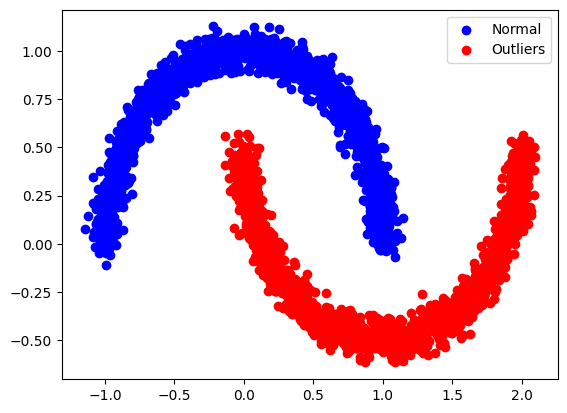

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
1000/5000 [D loss: 0.6924189329147339 | D Accuracy: 50.0] [G loss: 0.7590211033821106]
1/1 [==============================] - 0s 25ms/step
2000/5000 [D loss: 0.6595197916030884 | D Accuracy: 65.625] [G loss: 0.7427561283111572]
1/1 [==============================] - 0s 34ms/step
3000/5000 [D loss: 0.657312273979187 | D Accuracy: 76.5625] [G loss: 0.7457208633422852]
1/1 [==============================] - 0s 21ms/step
4000/5000 [D loss: 0.6681772172451019 | D Accuracy: 67.1875] [G loss: 0.704299807548523]
94/94 [==============================] - 0s 2ms/step


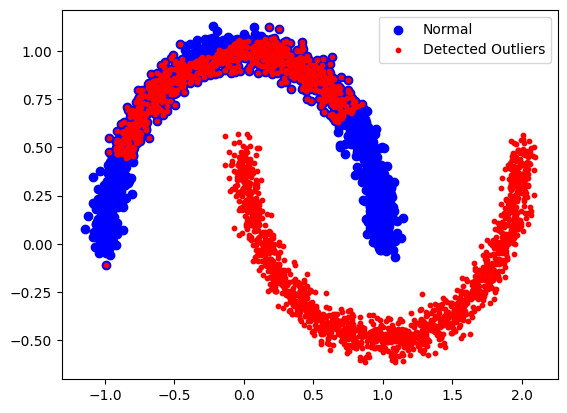

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate dataset
X, y = make_moons(n_samples=3000, noise=0.05, random_state=42)
X_normal = X[y == 0]
X_outliers = X[y == 1]

# Plot data
plt.scatter(X_normal[:, 0], X_normal[:, 1], color='blue', label='Normal')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red', label='Outliers')
plt.legend()
plt.show()

# Define the GAN components
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25, activation='relu', input_shape=(latent_dim,)),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_gan(generator, discriminator):
    model = tf.keras.Sequential([generator, discriminator])
    return model

# Hyperparameters
LATENT_DIM = 10
EPOCHS = 5000
BATCH_SIZE = 32

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build and compile the GAN
generator = build_generator(LATENT_DIM)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train GAN
for epoch in range(EPOCHS):
    # Training the discriminator
    idx = np.random.randint(0, X_normal.shape[0], BATCH_SIZE)
    true_samples = X_normal[idx]

    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    generated_samples = generator.predict(noise)

    labels_real = np.ones((BATCH_SIZE, 1))
    labels_fake = np.zeros((BATCH_SIZE, 1))

    d_loss_real = discriminator.train_on_batch(true_samples, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_samples, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Training the generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    valid_y = np.array([1] * BATCH_SIZE)
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"{epoch}/{EPOCHS} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Use the discriminator for outlier detection
threshold = 0.5  # probability threshold
X_all = np.vstack([X_normal, X_outliers])
y_pred = discriminator.predict(X_all)
outliers_pred = X_all[y_pred.ravel() < threshold]

# Plot detected outliers
plt.scatter(X_normal[:, 0], X_normal[:, 1], color='blue', label='Normal')
plt.scatter(outliers_pred[:, 0], outliers_pred[:, 1], color='red', s=10, label='Detected Outliers')
plt.legend()
plt.show()
